Connected to Athena successfully!
Fetching max CO2 emissions data...


/var/folders/9v/4smhr8lx3ws0xdwsw3xjy5zw0000gn/T/ipykernel_22514/709213217.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  max_co2_df = pd.read_sql(max_co2_query, conn)


Received data for 5 vehicles


/var/folders/9v/4smhr8lx3ws0xdwsw3xjy5zw0000gn/T/ipykernel_22514/709213217.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='vehicle_id', y='max_co2', data=max_co2_df, palette='viridis')


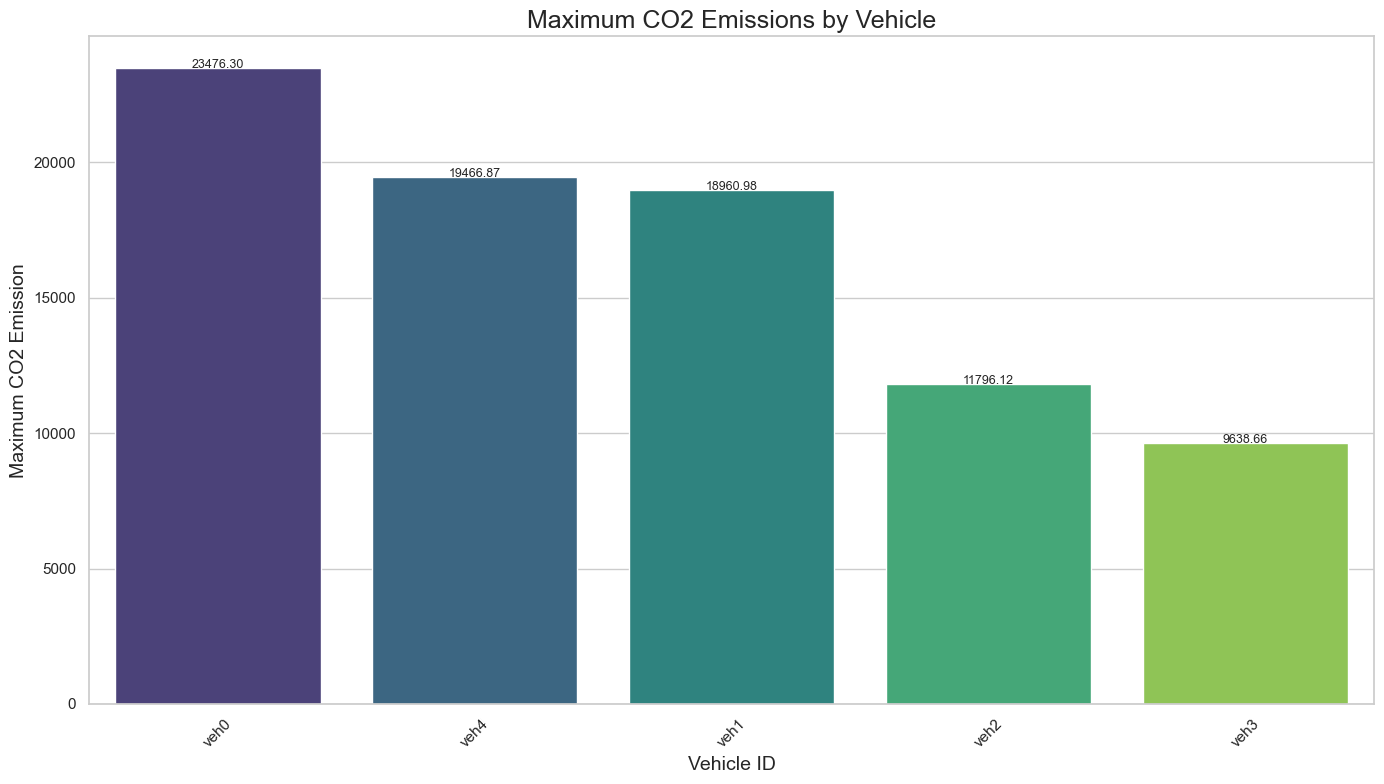


Fetching vehicle trajectory data...


/var/folders/9v/4smhr8lx3ws0xdwsw3xjy5zw0000gn/T/ipykernel_22514/709213217.py:91: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  trajectory_df = pd.read_sql(trajectory_query, conn)


Received trajectory data with 1390 data points
Plotting trajectories for 5 vehicles


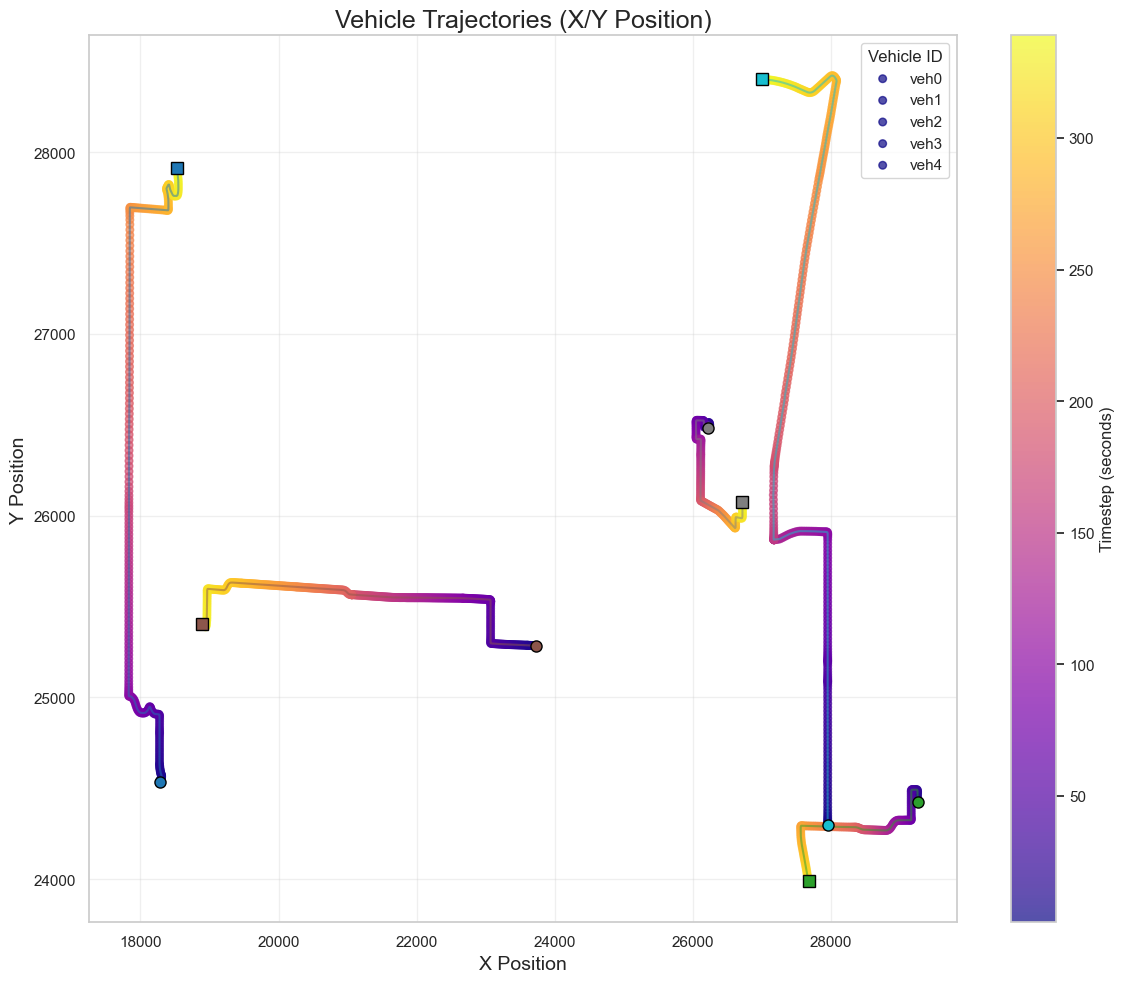


Fetching speed vs emissions data...


/var/folders/9v/4smhr8lx3ws0xdwsw3xjy5zw0000gn/T/ipykernel_22514/709213217.py:179: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  speed_emissions_df = pd.read_sql(speed_emissions_query, conn)


Received speed vs emissions data with 743 data points


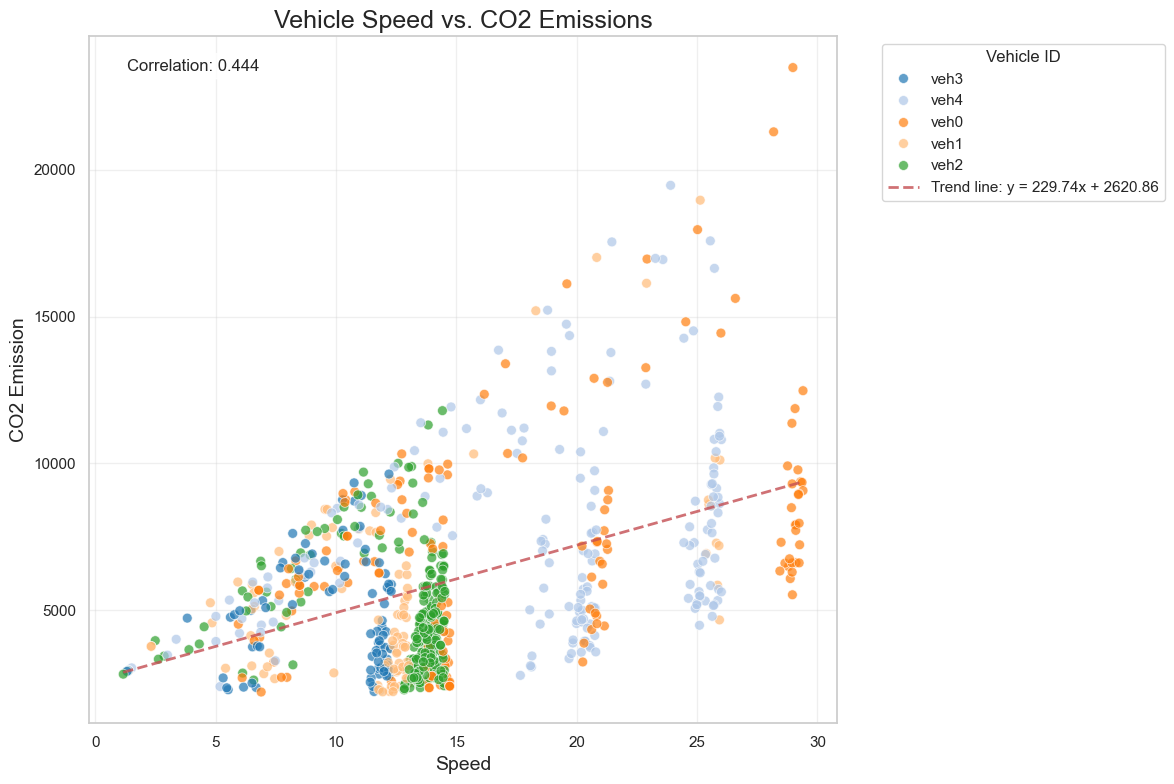


Summary Statistics:

Max CO2 Emissions by Vehicle:
            max_co2
count      5.000000
mean   16667.786000
std     5757.412934
min     9638.660000
25%    11796.120000
50%    18960.980000
75%    19466.870000
max    23476.300000

Speed vs. Emissions Correlation:
Correlation coefficient: 0.4439

Analysis complete. All visualizations have been generated.


In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyathena import connect

# Set plot style
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Establish connection to Athena
conn = connect(s3_staging_dir='s3://emissions-athena-results/',
               region_name='us-east-2')

print("Connected to Athena successfully!")

# ---------------------------------------------------
# VISUALIZATION 1: MAX CO2 EMISSIONS CHART
# ---------------------------------------------------
print("Fetching max CO2 emissions data...")

# Query to get the maximum CO2 emission for each vehicle
max_co2_query = """
SELECT 
    vehicle_id, 
    MAX(vehicle_co2) as max_co2
FROM 
    emissions_database.emissions_emissions_data_2
WHERE vehicle_id IS NOT NULL
GROUP BY 
    vehicle_id
ORDER BY 
    max_co2 DESC
"""

# Execute query and load into DataFrame
max_co2_df = pd.read_sql(max_co2_query, conn)
print(f"Received data for {len(max_co2_df)} vehicles")

# Create the max CO2 emissions chart
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='vehicle_id', y='max_co2', data=max_co2_df, palette='viridis')
plt.title('Maximum CO2 Emissions by Vehicle', fontsize=18)
plt.xlabel('Vehicle ID', fontsize=14)
plt.ylabel('Maximum CO2 Emission', fontsize=14)
plt.xticks(rotation=45)

# Add value labels on top of the bars
for i, v in enumerate(max_co2_df['max_co2']):
    ax.text(i, v + 0.5, f'{v:.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('max_co2_emissions.png', dpi=300)
plt.show()

# ---------------------------------------------------
# VISUALIZATION 2: VEHICLE TRAJECTORY (X/Y PLOT)
# ---------------------------------------------------
print("\nFetching vehicle trajectory data...")

# Query to get trajectory data for multiple vehicles
trajectory_query = """
WITH vehicle_samples AS (
    SELECT 
        vehicle_id,
        COUNT(*) as data_points
    FROM 
        emissions_database.emissions_emissions_data_2
    WHERE vehicle_id IS NOT NULL
    GROUP BY 
        vehicle_id
    HAVING 
        COUNT(*) > 10
    ORDER BY data_points DESC
)
SELECT 
    e.vehicle_id,
    e.vehicle_x, 
    e.vehicle_y,
    e.timestep_time
FROM 
    emissions_database.emissions_emissions_data_2 e
JOIN 
    vehicle_samples v ON e.vehicle_id = v.vehicle_id
ORDER BY 
    e.vehicle_id, e.timestep_time
"""

# Execute query and load into DataFrame
trajectory_df = pd.read_sql(trajectory_query, conn)
print(f"Received trajectory data with {len(trajectory_df)} data points")

# Plot vehicle trajectories
plt.figure(figsize=(12, 10))

# Get unique vehicle IDs
vehicles = trajectory_df['vehicle_id'].unique()
print(f"Plotting trajectories for {len(vehicles)} vehicles")

# Create a color map for vehicles
cmap = plt.cm.tab10
colors = cmap(np.linspace(0, 1, len(vehicles)))

# Plot each vehicle's trajectory separately
for i, vehicle in enumerate(vehicles):
    vehicle_data = trajectory_df[trajectory_df['vehicle_id'] == vehicle].sort_values('timestep_time')
    
    # Create a colormap based on timestep within this vehicle's data
    norm = plt.Normalize(vehicle_data['timestep_time'].min(), vehicle_data['timestep_time'].max())
    
    # Plot the scatter points with color representing timestep
    scatter = plt.scatter(vehicle_data['vehicle_x'], 
                         vehicle_data['vehicle_y'], 
                         c=vehicle_data['timestep_time'],
                         cmap='plasma',
                         norm=norm,
                         s=30, 
                         alpha=0.7,
                         label=vehicle)
    
    # Draw lines connecting the points in timestep order
    plt.plot(vehicle_data['vehicle_x'], 
             vehicle_data['vehicle_y'], 
             '-', 
             color=colors[i], 
             alpha=0.5,
             linewidth=1.5)
    
    # Mark the start and end points
    plt.plot(vehicle_data['vehicle_x'].iloc[0], 
             vehicle_data['vehicle_y'].iloc[0], 
             'o', 
             color=colors[i], 
             markersize=8,
             markeredgecolor='black')
    
    plt.plot(vehicle_data['vehicle_x'].iloc[-1], 
             vehicle_data['vehicle_y'].iloc[-1], 
             's', 
             color=colors[i], 
             markersize=8,
             markeredgecolor='black')

# Add colorbar for timestep
cbar = plt.colorbar(label='Timestep')
cbar.set_label('Timestep (seconds)', fontsize=12)

plt.title('Vehicle Trajectories (X/Y Position)', fontsize=18)
plt.xlabel('X Position', fontsize=14)
plt.ylabel('Y Position', fontsize=14)
plt.legend(title='Vehicle ID', title_fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('vehicle_trajectories.png', dpi=300)
plt.show()

# ---------------------------------------------------
# VISUALIZATION 3: SPEED VS EMISSIONS CHART
# ---------------------------------------------------
print("\nFetching speed vs emissions data...")

# Query to get speed and emissions data
speed_emissions_query = """
SELECT 
    vehicle_id,
    vehicle_speed, 
    vehicle_co2
FROM 
    emissions_database.emissions_emissions_data_2
WHERE 
    vehicle_speed > 0
    AND vehicle_co2 > 0
    AND vehicle_id IS NOT NULL

"""

# Execute query and load into DataFrame
speed_emissions_df = pd.read_sql(speed_emissions_query, conn)
print(f"Received speed vs emissions data with {len(speed_emissions_df)} data points")

# Plot speed vs emissions with regression line
plt.figure(figsize=(12, 8))

# Create scatter plot
sns.scatterplot(
    x='vehicle_speed', 
    y='vehicle_co2', 
    hue='vehicle_id',
    data=speed_emissions_df,
    alpha=0.7,
    palette='tab20',
    s=50
)

# Calculate and add regression line
x = speed_emissions_df['vehicle_speed']
y = speed_emissions_df['vehicle_co2']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

# Add regression line to plot
x_range = np.linspace(x.min(), x.max(), 100)
plt.plot(x_range, p(x_range), "r--", linewidth=2, alpha=0.8, label=f'Trend line: y = {z[0]:.2f}x + {z[1]:.2f}')

# Calculate correlation
correlation = speed_emissions_df['vehicle_speed'].corr(speed_emissions_df['vehicle_co2'])

# Add annotation with correlation coefficient
plt.annotate(f'Correlation: {correlation:.3f}', 
             xy=(0.05, 0.95), 
             xycoords='axes fraction', 
             fontsize=12,
             bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

plt.title('Vehicle Speed vs. CO2 Emissions', fontsize=18)
plt.xlabel('Speed', fontsize=14)
plt.ylabel('CO2 Emission', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(title='Vehicle ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('speed_vs_emissions.png', dpi=300)
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("\nMax CO2 Emissions by Vehicle:")
print(max_co2_df.describe())

print("\nSpeed vs. Emissions Correlation:")
print(f"Correlation coefficient: {correlation:.4f}")

# Close the connection
conn.close()
print("\nAnalysis complete. All visualizations have been generated.")